## Top-level Global Var

In [1]:
DEBUG = 8

## Imports

In [2]:
import argparse
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
from os.path import dirname
import random
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import tqdm

if DEBUG>0:
    from utils.models1 import Classifier
else:
    from utils.models import Classifier
from utils.dataset import NCaltech101
from utils.loader import Loader
from utils.train_eval import train_one_epoch, eval_one_epoch

if DEBUG>=8:
    if DEBUG==9:
        seed = 1587382387
    else:
        import time
        seed = int( time.time())
    print("Seed: %d" % seed)
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

Seed: 1587549366


In [3]:
class FLAGS:
    # To use N-Caltech101 data, uncomment 4 lines below
    validation_dataset = 'N-Caltech101/validation'
    training_dataset = 'N-Caltech101/training'
    height = 180
    width = 240
    # To use celeX data, uncomment 4 lines below
    # validation_dataset = 'celeX_files/npy'
    # training_dataset = 'celeX_files/npy'
    # height = 800
    # width = 1280
    
    log_dir = 'log/temp'
    device = 'cuda'
    num_workers = 8
    pin_memory = True
    batch_size = 16
    num_epochs = 60
    save_every_n_epochs = 5
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"----------------------------\n"
                  f"Starting training with \n"
                  f"height: {self.height}\n"
                  f"width: {self.width}\n"
                  f"num_epochs: {self.num_epochs}\n"
                  f"batch_size: {self.batch_size}\n"
                  f"device: {self.device}\n"
                  f"log_dir: {self.log_dir}\n"
                  f"training_dataset: {self.training_dataset}\n"
                  f"validation_dataset: {self.validation_dataset}\n"
                  f"num_workers: {self.num_workers}\n"
                  f"pin_memory: {self.pin_memory}\n"
                  f"----------------------------")

In [4]:
flags = FLAGS()
dim = (flags.height, flags.width)

# datasets, add augmentation to training set
training_dataset = NCaltech101(flags.training_dataset, augmentation=True, resolution=dim)
validation_dataset = NCaltech101(flags.validation_dataset, resolution=dim)

datasetClasses = training_dataset.getClasses()

# construct loader, handles data streaming to gpu
training_loader = Loader(training_dataset, flags, device=flags.device)
validation_loader = Loader(validation_dataset, flags, device=flags.device)

# model, and put to device
model = Classifier(device=flags.device, dimension=dim)
model = model.to(flags.device)

# optimizer and lr scheduler
optimizerSelect = 'adam'
if optimizerSelect == 'sgd':
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, momentum=0.9, weight_decay=1e-5)
elif optimizerSelect == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

----------------------------
Starting training with 
height: 180
width: 240
num_epochs: 1
batch_size: 16
device: cpu
log_dir: log/temp
training_dataset: N-Caltech101/training
validation_dataset: N-Caltech101/validation
num_workers: 8
pin_memory: True
----------------------------


tensor([53,  1, 12, 66, 49, 48, 92, 23,  3,  5, 35, 76, 46, 39, 72, 96])


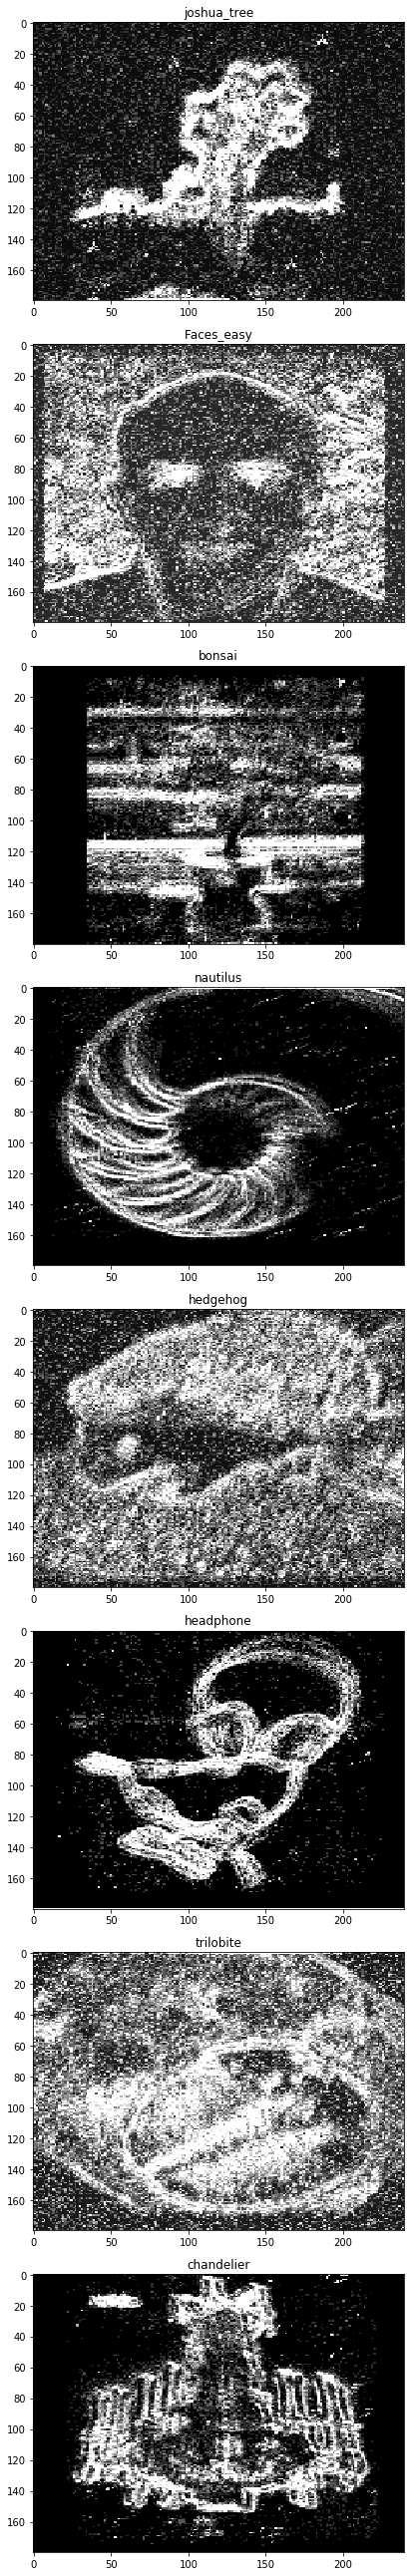

In [5]:
""" Visualization of training set """
itr = iter(validation_loader)
events, labels = next(itr)
model.setMode(0)
preprocessed = model.quantization_layer.forward(events)
preprocessed = model.crop_and_resize_to_resolution(preprocessed, dim)
# preprocessed = model.medianFilter(preprocessed)
preprocessed = preprocessed.cpu().numpy()

print(labels)

fig = plt.figure(figsize=(18, 36))
ax = []
rows = 8
columns = 1
for i in range(rows * columns):
    ax.append( fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title( datasetClasses[ labels[i].item()])
    plt.imshow(preprocessed[i][0], cmap='gray', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

tensor([ 1, 84,  1,  5, 92,  5, 61, 68,  0,  3, 78,  2,  5, 54, 92,  2])


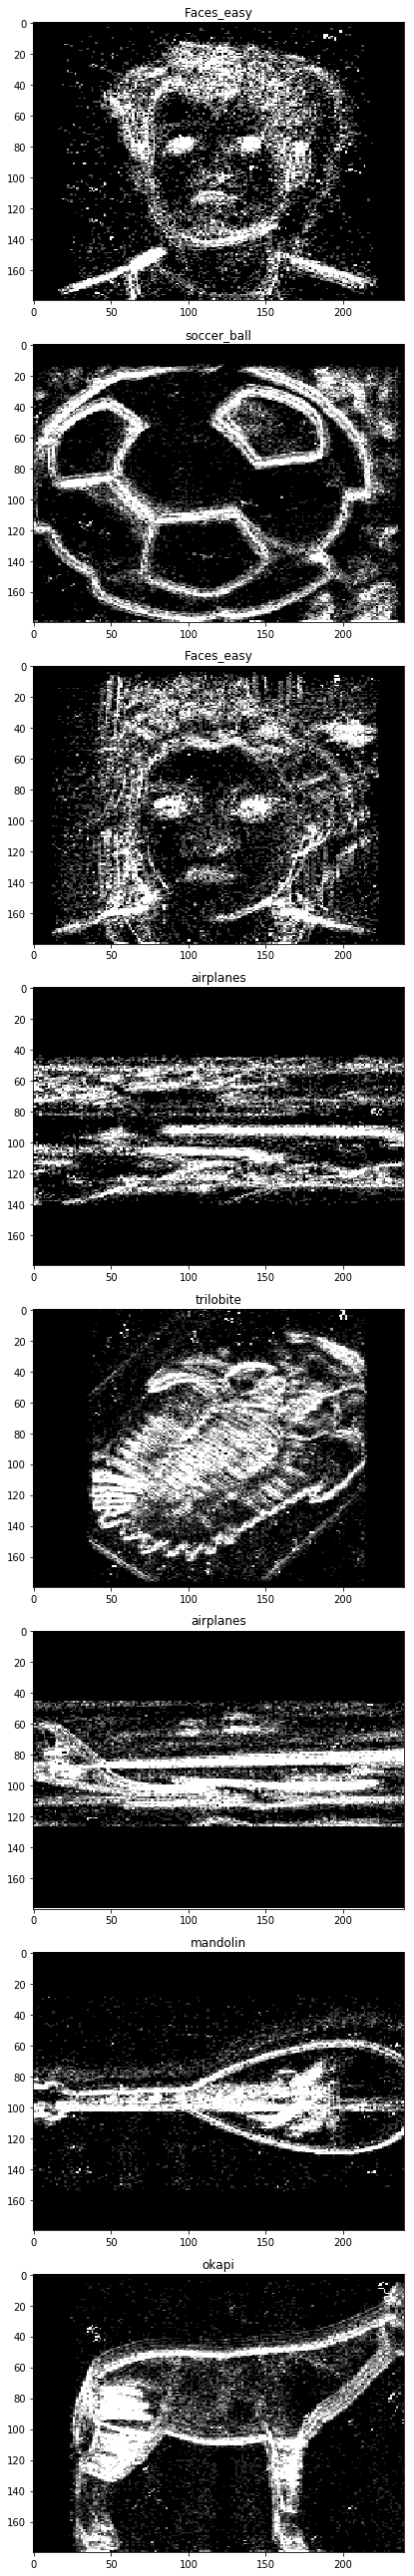

In [6]:
""" Visualization of validation set """
itr = iter(validation_loader)
events, labels = next(itr)
model.setMode(1)
preprocessed = model.quantization_layer.forward(events)
preprocessed = model.crop_and_resize_to_resolution(preprocessed, dim)
# preprocessed = model.medianFilter(preprocessed)
preprocessed = preprocessed.cpu().numpy()

print(labels)

fig = plt.figure(figsize=(18, 36))
ax = []
rows = 8
columns = 1
for i in range(rows * columns):
    ax.append( fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title( datasetClasses[ labels[i].item()])
    plt.imshow(preprocessed[i][0], cmap='gray', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

In [7]:
iteration = 0
min_validation_loss = 1000
train_acc, eval_acc = [], []

for i in range(flags.num_epochs):

    print(f"Training step [{i:3d}/{flags.num_epochs:3d}]")
    model = model.train()
    model.setMode(0)
    training_loss, training_accuracy, iteration = train_one_epoch(model, flags.device, optimizer, training_loader, iteration)
    print(f"Training Iteration {iteration:5d}  Loss {training_loss:.4f}  Accuracy {training_accuracy:.4f}")
    train_acc.append(training_accuracy)
    
    if i%10 == 9:
        if optimizerSelect == 'adam':
            lr_scheduler.step()

    if i%1 == 0:
        print(f"Validation step [{i:3d}/{flags.num_epochs:3d}]")
        model = model.eval()
        model.setMode(1)
        validation_loss, validation_accuracy = eval_one_epoch(model, flags.device, validation_loader)
        print(f"Validation Loss {validation_loss:.4f}  Accuracy {validation_accuracy:.4f}")
        eval_acc.append(validation_accuracy)
        
        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            state_dict = model.state_dict()
            torch.save({
                "state_dict": state_dict,
                "min_val_loss": min_validation_loss,
                "iteration": iteration
            }, "log/model_best.pth")
            print("New best at ", validation_loss)
        if i % flags.save_every_n_epochs == 0:
            state_dict = model.state_dict()
            torch.save({
                "state_dict": state_dict,
                "min_val_loss": min_validation_loss,
                "iteration": iteration
            }, "log/checkpoint_%05d_%.4f.pth" % (iteration, min_validation_loss))

Training step [  0/  1]


 94%|███████████████████████████████████████████████████████████████████████████     | 256/273 [25:22<02:48,  9.93s/it]

KeyboardInterrupt: 

In [ ]:
""" Visualizing Training Results """
fig, ax = plt.subplots()
plt.title("Training Result")

ax.plot(train_acc, label='Training')
ax.plot(eval_acc, label='Validation')

plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()